# Image Processing Algorithms

In [202]:
%matplotlib inline
from scipy.ndimage.filters import convolve
from skimage.filters import gaussian
import numpy as np
from numpy.random import default_rng
from random import randint
from ipywidgets import interact
from matplotlib import image as img
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['image.cmap'] = 'gray'

# Constants
RED = 0
GREEN = 1
BLUE = 2
ALPHA = 3
CHANNELS = [RED, GREEN, BLUE, ALPHA]

# Normalize image
normalize = lambda image: (image - image.min()) / (image.max() - image.min())

Load image of my face

Image: float32 (3088, 2316, 4)


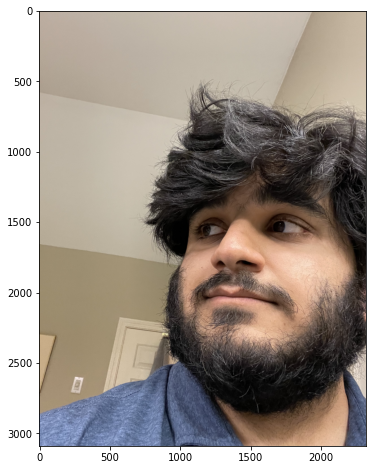

In [172]:
photo = img.imread('data/melol.png')
print('Image:', photo.dtype, photo.shape)
plt.figure();
plt.imshow(photo)
plt.show();

## Screen-Door effect Filter

Shift color channels. Get an old timey TV effect, since most TV's are scanned horizontally first then vertically, my prediction is that the distortion will most likely be horizontal rather than vertical.

This filter is randomized. Rerun the cell to get a new image

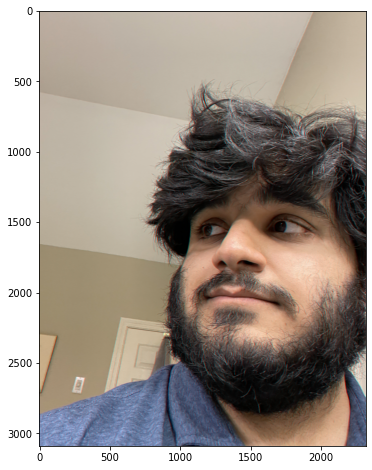

In [173]:
# Shifts
shift = default_rng().integers(low=-25, high=25, size=3)

# Do channel shift
screendoor = np.array(photo)
for chan in range(3):
    if shift[chan] > 0:
        screendoor[:,:-shift[chan],chan] = photo[:,shift[chan]:,chan]
    elif shift[chan] < 0:
        screendoor[:,-shift[chan]:,chan] = photo[:,:shift[chan],chan]

# Show photo
plt.figure()
plt.imshow(screendoor);

## Edge Filters

Going to try and detect edges. Will use grayscale for now

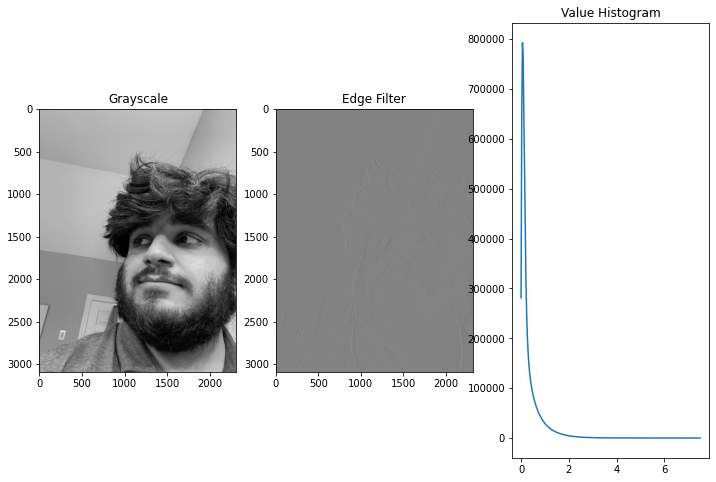

In [174]:
# Grayscale photo
grayscale = np.sum(photo, axis=2)

# Horizontal edge detector
h_edge_kernel = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ], 
    dtype=np.float64
).reshape((3, 3))

h_edge = convolve(grayscale, h_edge_kernel)
p, x = np.histogram(edge, bins=256)

plt.figure()
plt.subplot(1,3,1)
plt.imshow(grayscale)
plt.title('Grayscale')
plt.subplot(1,3,2)
plt.imshow(h_edge)
plt.title('Edge Filter')
plt.subplot(1,3,3)
plt.plot(x[:-1], p)
plt.title('Value Histogram')
plt.show();

Okay the edge detector was written properly.... However the edge detector image is pretty gray, although I can see the features there... The majority of the values are gray... Am I doing this wrong? I'll try normalizing the image. 

This following cell corresponds with the one above.

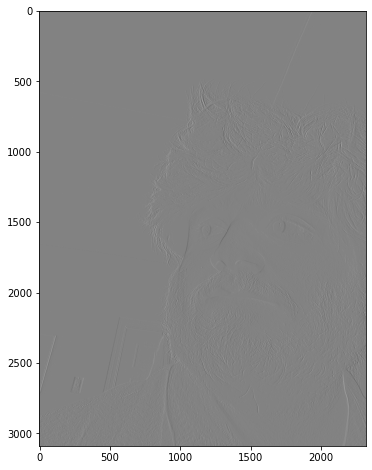

In [175]:
normalize_h_edge = normalize(h_edge)
plt.figure();
plt.imshow(normalize_h_edge)
plt.show();

Didn't work. I can see the edge definitions. But it's still gray. I kind of know why.

In [176]:
print(h_edge.min(), h_edge.max())

-9.945098 9.54902


There are still numbers in the far extremes. I could just do a boolean threshold image. Let's try that

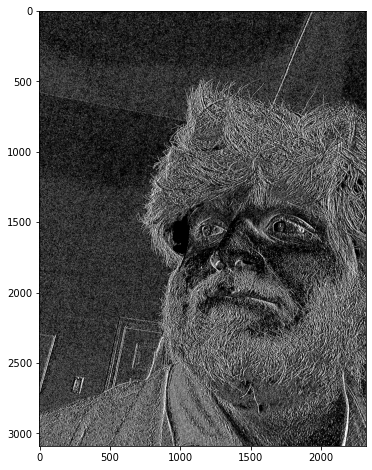

In [177]:
thresh_h_edge = (h_edge > 0.15)

plt.figure();
plt.imshow(thresh_h_edge);
plt.show();

I look like the sage that I am ;-). I'll try blurring the image before edge detection first

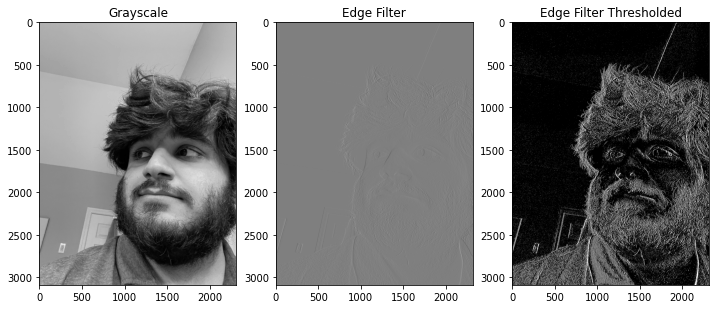

In [178]:
# Grayscale photo
grayscale = np.sum(photo, axis=2)

# Horizontal edge detector
h_edge_kernel = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=np.float64)

# Run filter
h_edge = convolve(grayscale, blur_kernel)
h_edge = convolve(h_edge, h_edge_kernel)

# Threshold maybe?
h_edge_thresh = (h_edge > 0.2).astype(np.uint8)

plt.figure()
plt.subplot(1,3,1)
plt.imshow(grayscale)
plt.title('Grayscale')
plt.subplot(1,3,2)
plt.imshow(h_edge)
plt.title('Edge Filter')
plt.subplot(1,3,3)
plt.imshow(h_edge_thresh)
plt.title('Edge Filter Thresholded')
plt.show();

Now we'll do both horizontal and vertical edges and get a scaled value

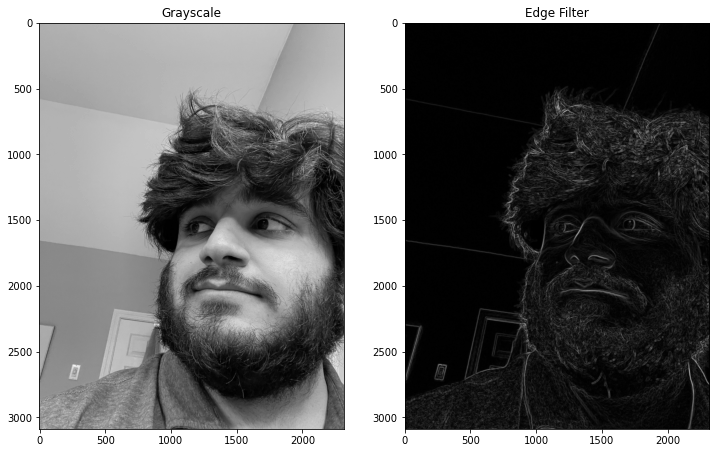

In [222]:
# Grayscale photo
grayscale = np.sum(photo, axis=2)

# Horizontal edge detector
h_edge_kernel = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=np.float64)
v_edge_kernel = np.array([
    [ 1,  2,  1],
    [ 0,  0,  0],
    [-1, -2, -1]
], dtype=np.float64)

# Run filter
blurred = gaussian(grayscale, sigma=3)
h_edge = convolve(blurred, h_edge_kernel)
v_edge = convolve(blurred, v_edge_kernel)
edge = np.sqrt(h_edge**2 + v_edge**2)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(grayscale)
plt.title('Grayscale')
plt.subplot(1,2,2)
plt.imshow(edge)
plt.title('Edge Filter')
plt.show();

I just realized something. This entire time, I only needed to get the absolute value... That would get my horizontal and vertical filters.... if I needed that...

Screw it, I'm doing that just to prove a point

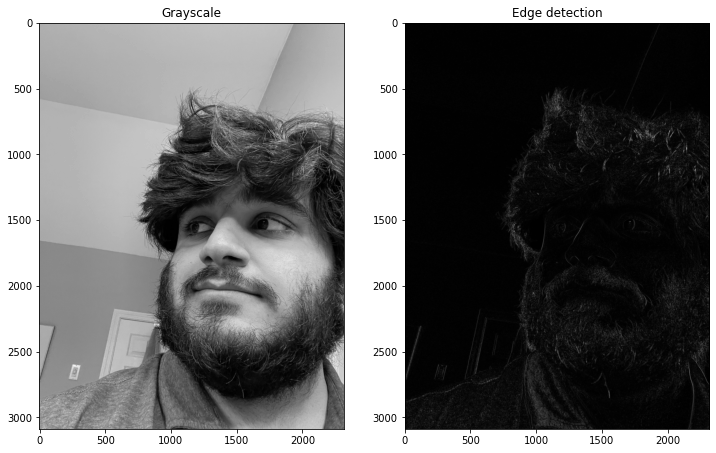

In [204]:
# Grayscale photo
grayscale = np.sum(photo, axis=2)

# Horizontal edge detector
h_edge_kernel = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=np.float64)

# Run filter
blurred = gaussian(grayscale)
h_edge = convolve(blurred, h_edge_kernel)
h_edge = np.abs(h_edge)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(grayscale)
plt.title('Grayscale')
plt.subplot(1,2,2)
plt.imshow(h_edge)
plt.title('Edge detection')
plt.show();

Yep...

What happens if I combine the edge one and the grayscale...

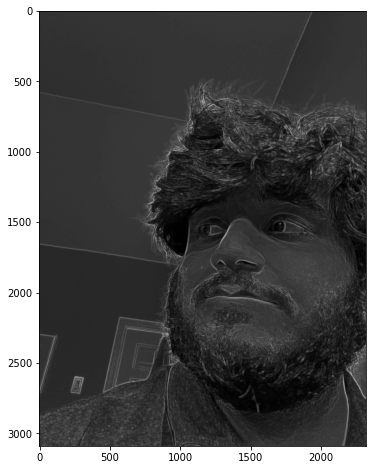

In [223]:
# First normalize both
grayscale_norm = normalize(grayscale)
edge_norm = normalize(edge)

# Combine both (weight edge image)
# Normalize for good measure
alpha = 0.75
interpolate = normalize(grayscale_norm*(1 - alpha) + edge_norm*(alpha))

# Show image
plt.figure()
plt.imshow(interpolate)
plt.show();

This is an actually cool image... I might have an idea for it... what if I took my original image and added this boundary to it

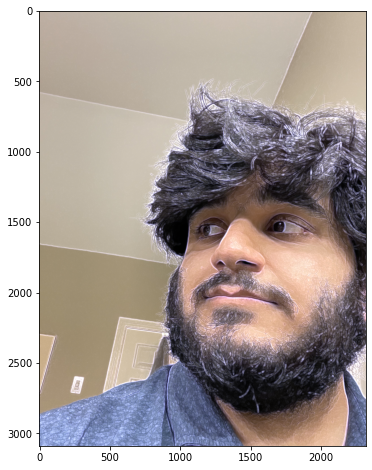

In [225]:
halo = 5 * np.array([[[ 0.2, 0.2, 0.3, 0.0 ]]])
halo = np.expand_dims(edge_norm, axis=2) * halo
halo_effect = (photo + halo).clip(0, 1)
plt.figure()
plt.imshow(halo_effect)
plt.show();